In [19]:
from mind_the_gaps.lightcurves import GappyLightcurve
from mind_the_gaps.gpmodelling import GPModelling, GPModellingComparison
from mind_the_gaps.models.psd_models import BendingPowerlaw, Lorentzian, SHO, Matern32, Jitter
from mind_the_gaps.models import Lorentzian as Lor
from mind_the_gaps.models.celerite.celerite_models import DampedRandomWalk
from mind_the_gaps.simulator import Simulator
import numpy as np
import matplotlib.pyplot as plt
import celerite, corner
from scipy.stats import percentileofscore
from mind_the_gaps.models.kernel_spec import (
    KernelParameterSpec,
    KernelSpec,
    KernelTermSpec,
)

cpus = 10 # set the number of cores for parallelization
np.random.seed(10)



## Case of No period

# Define parameters for lightcurve simulation

In [20]:
times  = np.arange(0, 1000)
dt = np.diff(times)[0]

mean = 100

#A = (mean * 0.1) ** 2 # variance of the lorentzian
#Q = 80
variance_drw = (mean * 0.1) ** 2  # variance of the DRW (bending powerlaw)
w_bend = 2 * np.pi / 20 # angular frequency of the DRW or Bending Powerlaw

# define the PSD model
psd_model = BendingPowerlaw(variance_drw, w_bend) 

# Simulate lightcurve

/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Text(0, 0.5, 'Rates (ct/s)')

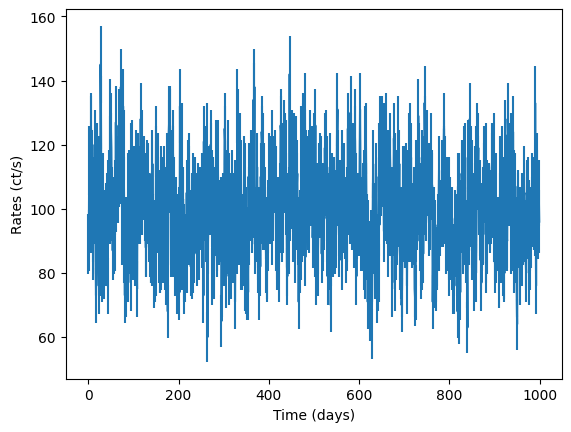

In [21]:
# create simulator object
simulator = Simulator(psd_model, times, np.ones(len(times)) * dt, mean, pdf="Gaussian", 
                     extension_factor=2)
# simulate noiseless count rates from the PSD, make the initial lightcurve 2 times as long as the original times
countrates = simulator.generate_lightcurve()
# add (Poisson) noise
noisy_countrates, dy = simulator.add_noise(countrates)

input_lc = GappyLightcurve(times, noisy_countrates, dy, exposures=dt)

fig = plt.figure()
plt.errorbar(times, noisy_countrates, yerr=dy)
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# Define null and alternative hypothesis

In [22]:
# null 
bounds_drw = dict(log_a=(-10, 50), log_c=(-10, 10))
# you can use RealTerm from celerite or DampedRandomWalk from models.celerite_models
#null_kernel = celerite.terms.RealTerm(log_a=np.log(variance_drw), log_c=np.log(w_bend), bounds=bounds_drw)
null_spec =  KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=celerite.terms.RealTerm,
                parameters={
                    "log_a": KernelParameterSpec(
                        value=np.log(variance_drw), bounds=(-10, 50)
                    ),
                    "log_c": KernelParameterSpec(
                        value=np.log(w_bend), bounds=(-10, 10)
                    ),
                },
            )
        ],
    )

P = 10 # period of the QPO
w = 2 * np.pi / P
# Define starting parameters
log_variance_qpo = np.log(variance_drw)
Q = 80 # coherence
log_c = np.log(0.5 * w/Q)
log_d = np.log(w)

alternative_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=celerite.terms.ComplexTerm,
                parameters={
                    "log_a": KernelParameterSpec(
                        value=log_variance_qpo, bounds=(-10, 50)
                    ),
                    "log_c": KernelParameterSpec(value=log_c, bounds=(-10, 10)),
                    "log_d": KernelParameterSpec(value=log_d, bounds=(-5, 5)),
                },
            ),
            KernelTermSpec(
                term_class=celerite.terms.RealTerm,
                parameters={
                    "log_a": KernelParameterSpec(
                        value=np.log(variance_drw), bounds=(-10, 50)
                    ),
                    "log_c": KernelParameterSpec(
                        value=np.log(w_bend), bounds=(-10, 10)
                    ),
                },
            ),
        ],
    )




# Set up GP Model Comparison

In [23]:
comparison_kwargs = {
        "null_kwargs": {
            "fit_mean": True,
            "cpus": 10,
        },
        "alt_kwargs": {
            "fit_mean": True,
            "cpus": 10,
        },
    }
gp_model_comp = GPModellingComparison(
        null_kernel_spec=null_spec,
        alt_kernel_spec=alternative_spec,
        lightcurve=input_lc,
        **comparison_kwargs,
    )

# Derive posteriors for both models lightcurves from null hypothesis posteriors

In [24]:

gp_model_comp.derive_posteriors(fit=True, max_steps=50000, cores=cpus)

 16%|█▌        | 8000/50000 [00:22<02:00, 349.46it/s]


Convergence reached after 8000 samples!


 52%|█████▏    | 26000/50000 [01:43<01:35, 251.45it/s]


Convergence reached after 26000 samples!


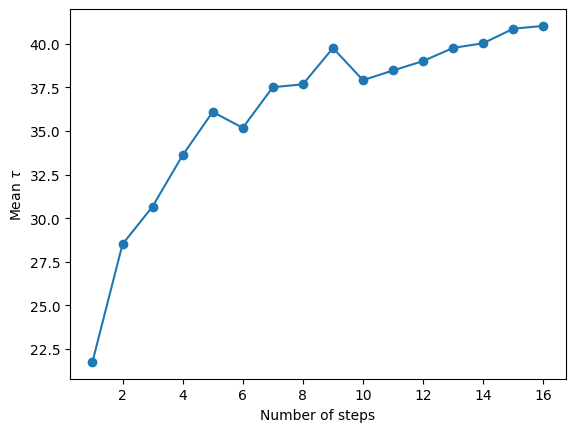

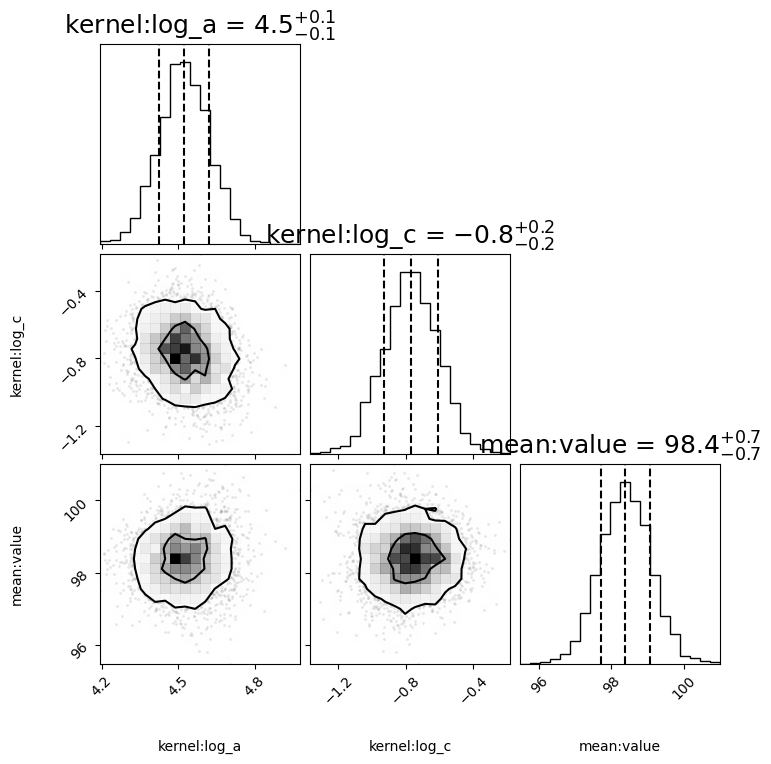

In [25]:
gp_model_comp.null_model.plot_autocorrelation()
gp_model_comp.null_model.corner_plot_samples()

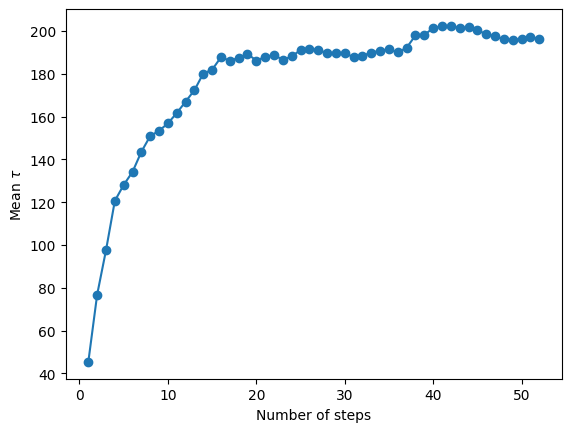

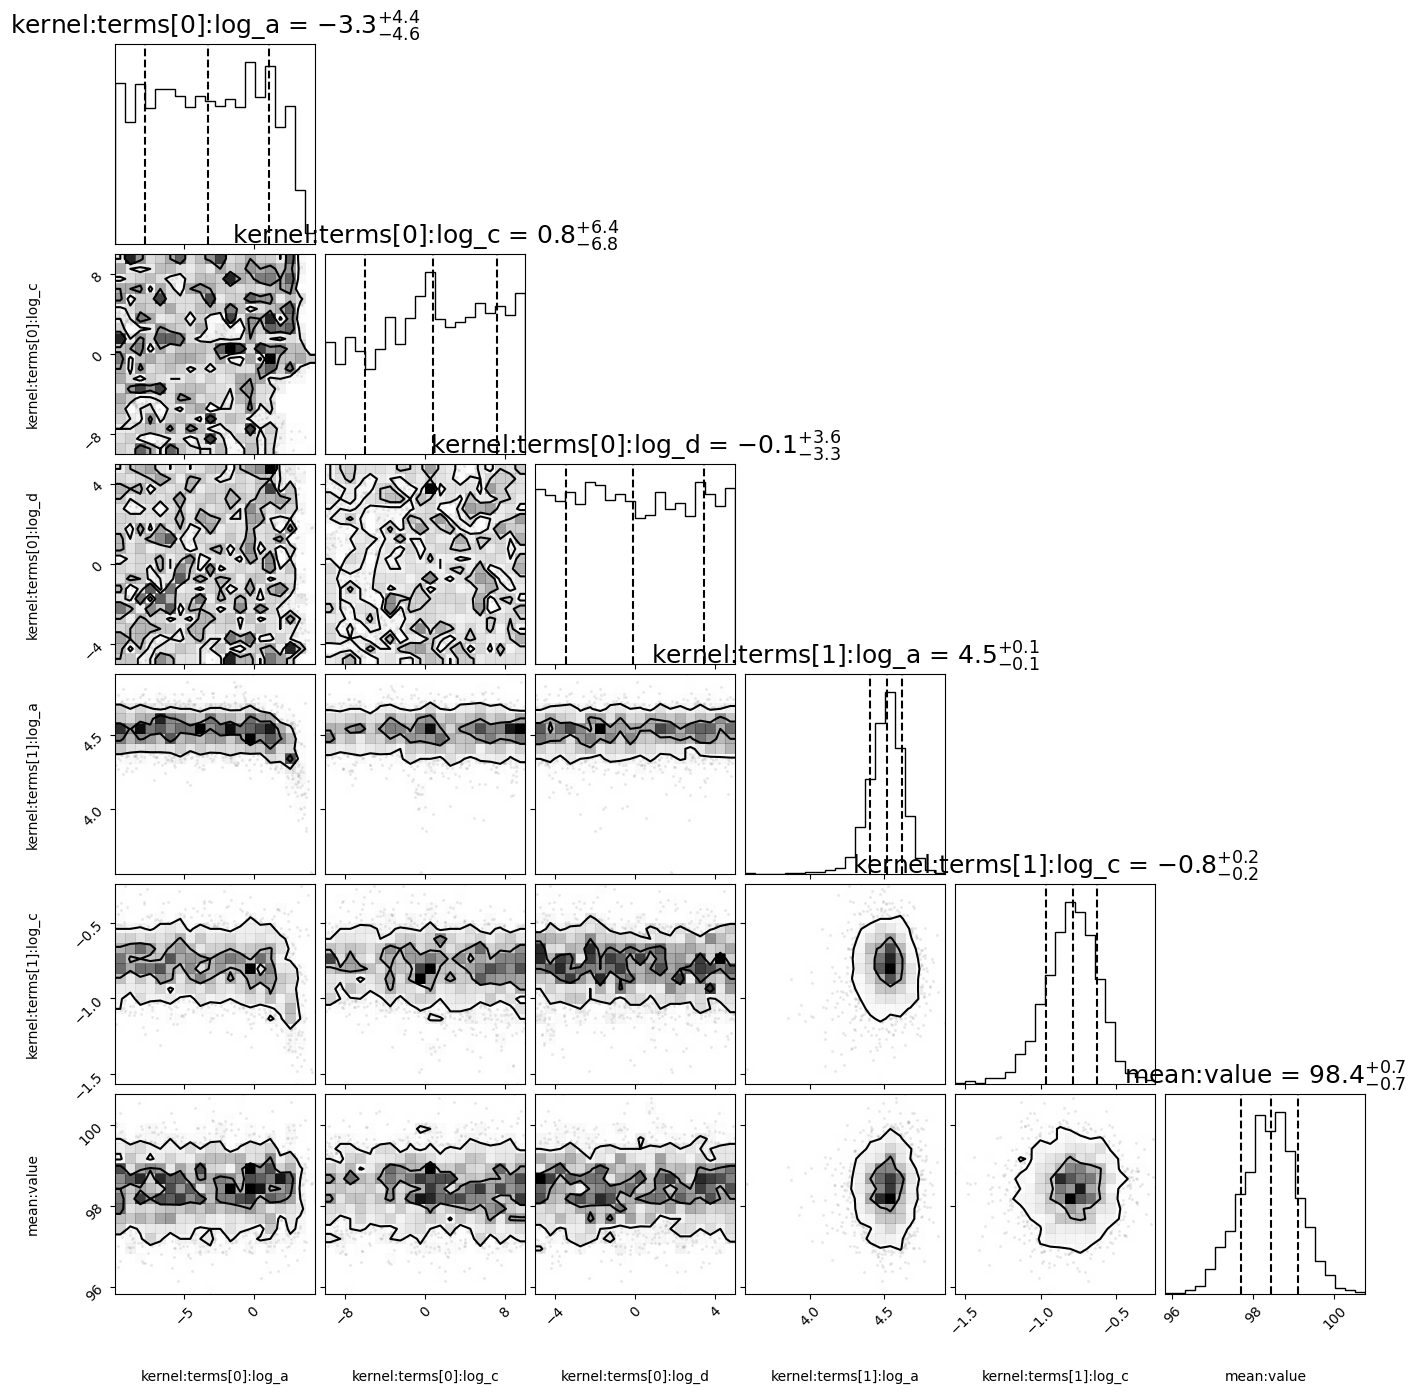

In [26]:
gp_model_comp.alt_model.plot_autocorrelation()
gp_model_comp.alt_model.corner_plot_samples()

# Generate lightcurves, and fit with both null and alternative models

In [27]:
gp_model_comp.process_lightcurves(nsims=100, fit=True, max_steps=1000, cores=cpus)

/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/connorourke/

100%|██████████| 1000/1000 [00:03<00:00, 289.04it/s]


100%|██████████| 1000/1000 [00:03<00:00, 280.46it/s]


100%|██████████| 1000/1000 [00:03<00:00, 305.17it/s]


100%|██████████| 1000/1000 [00:03<00:00, 312.04it/s]


100%|██████████| 1000/1000 [00:03<00:00, 286.14it/s]


KeyboardInterrupt: 

# Perform Likelihood Ratio Test

In [ ]:
gp_model_comp.likelihood_ratio_test(path="LRT_no_period.png")

We see the p-value to reject the null hypothesis is fairly low, indicating there is no signal in this data, as expected

# Case with Period

# Simulate lightcurve

In [28]:
times  = np.arange(0, 500)
dt = np.diff(times)[0]

mean = 100

P = 10 # period of the QPO
w_qpo = 2 * np.pi / P
w_bend = 2 * np.pi / 20 # angular frequency of the DRW or Bending Powerlaw
# Define starting parameters
variance_drw = (mean * 0.1) ** 2  # variance of the DRW (bending powerlaw)
variance_qpo = variance_drw # let's assume same variance for the QPO and the DRW

Q = 80 # coherence

psd_model = Lorentzian(variance_qpo, Q, w_qpo) + BendingPowerlaw(variance_drw, w_bend) 

Text(0, 0.5, 'Rates (ct/s)')

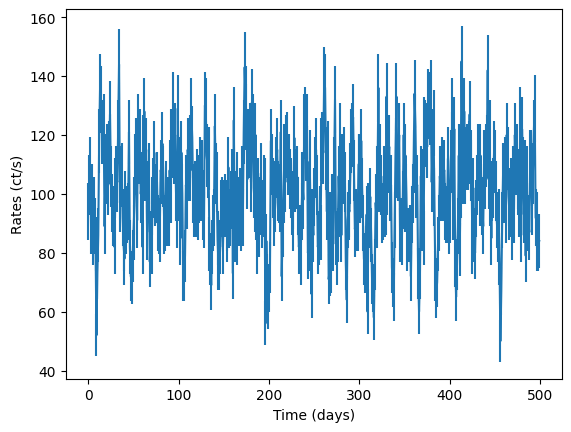

In [29]:
simulator = Simulator(psd_model, times, np.ones(len(times)) * dt, mean, pdf="Gaussian", max_iter=500)

rates = simulator.generate_lightcurve()
noisy_rates, dy = simulator.add_noise(rates)

input_lc = GappyLightcurve(times, noisy_rates, dy, exposures=dt)

fig = plt.figure()
plt.errorbar(times, noisy_rates, yerr=dy)
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# Define null hypothesis

In [30]:

null_kernel_spec =  KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=celerite.terms.RealTerm,
                parameters={
                    "log_a": KernelParameterSpec(
                        value=np.log(variance_drw), bounds=(-10, 50)
                    ),
                    "log_c": KernelParameterSpec(
                        value=np.log(w_bend), bounds=(-10, 10)
                    ),
                },
            )
        ],
    )



# Define alternative model

In [31]:
log_c = np.log(0.5 * w_qpo/Q)
log_d = np.log(w_qpo)
bounds_qpo = dict(log_a=(-10, 50), log_c=(-10, 10), log_d=(-5, 5))
# again you may use the Lorentzian from models.celerite_models

alternative_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=celerite.terms.ComplexTerm,
                parameters={
                    "log_a": KernelParameterSpec(
                        value=log_variance_qpo, bounds=(-10, 50)
                    ),
                    "log_c": KernelParameterSpec(value=log_c, bounds=(-10, 10)),
                    "log_d": KernelParameterSpec(value=log_d, bounds=(-5, 5)),
                },
            ),
            KernelTermSpec(
                term_class=celerite.terms.RealTerm,
                parameters={
                    "log_a": KernelParameterSpec(
                        value=np.log(variance_drw), bounds=(-10, 50)
                    ),
                    "log_c": KernelParameterSpec(
                        value=np.log(w_bend), bounds=(-10, 10)
                    ),
                },
            ),
        ],
    )




# Set up GP Model Comparison

In [32]:
comparison_kwargs = {
        "null_kwargs": {
            "fit_mean": True,
            "cpus": 10,
        },
        "alt_kwargs": {
            "fit_mean": True,
            "cpus": 10,
        },
    }
gp_model_comp = GPModellingComparison(
        null_kernel_spec=null_spec,
        alt_kernel_spec=alternative_spec,
        lightcurve=input_lc,
        **comparison_kwargs,
    )

# Derive Posteriors for null and alternative models

In [33]:
gp_model_comp.derive_posteriors(fit=True, max_steps=50000, cores=cpus)

 20%|██        | 10000/50000 [00:23<01:34, 423.57it/s]


Convergence reached after 10000 samples!


 25%|██▌       | 12500/50000 [00:41<02:04, 301.65it/s]


Convergence reached after 12500 samples!


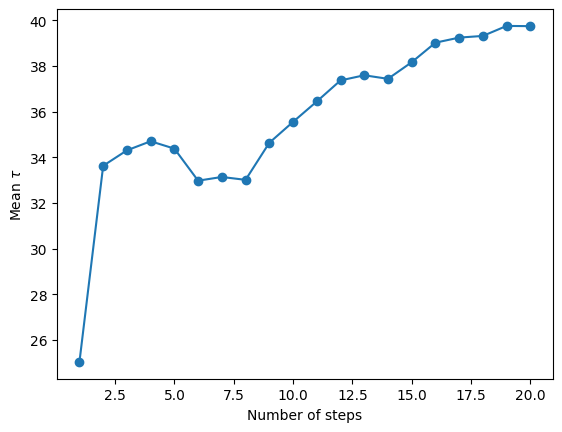

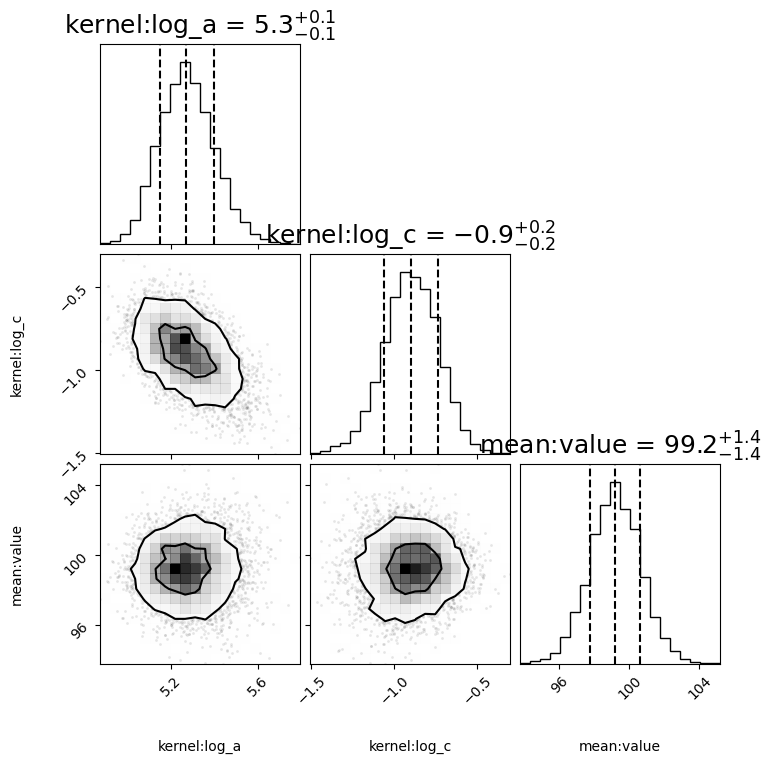

In [34]:
gp_model_comp.null_model.plot_autocorrelation()
gp_model_comp.null_model.corner_plot_samples()

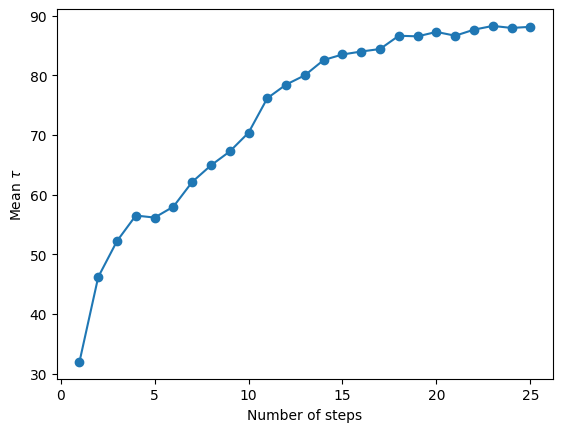

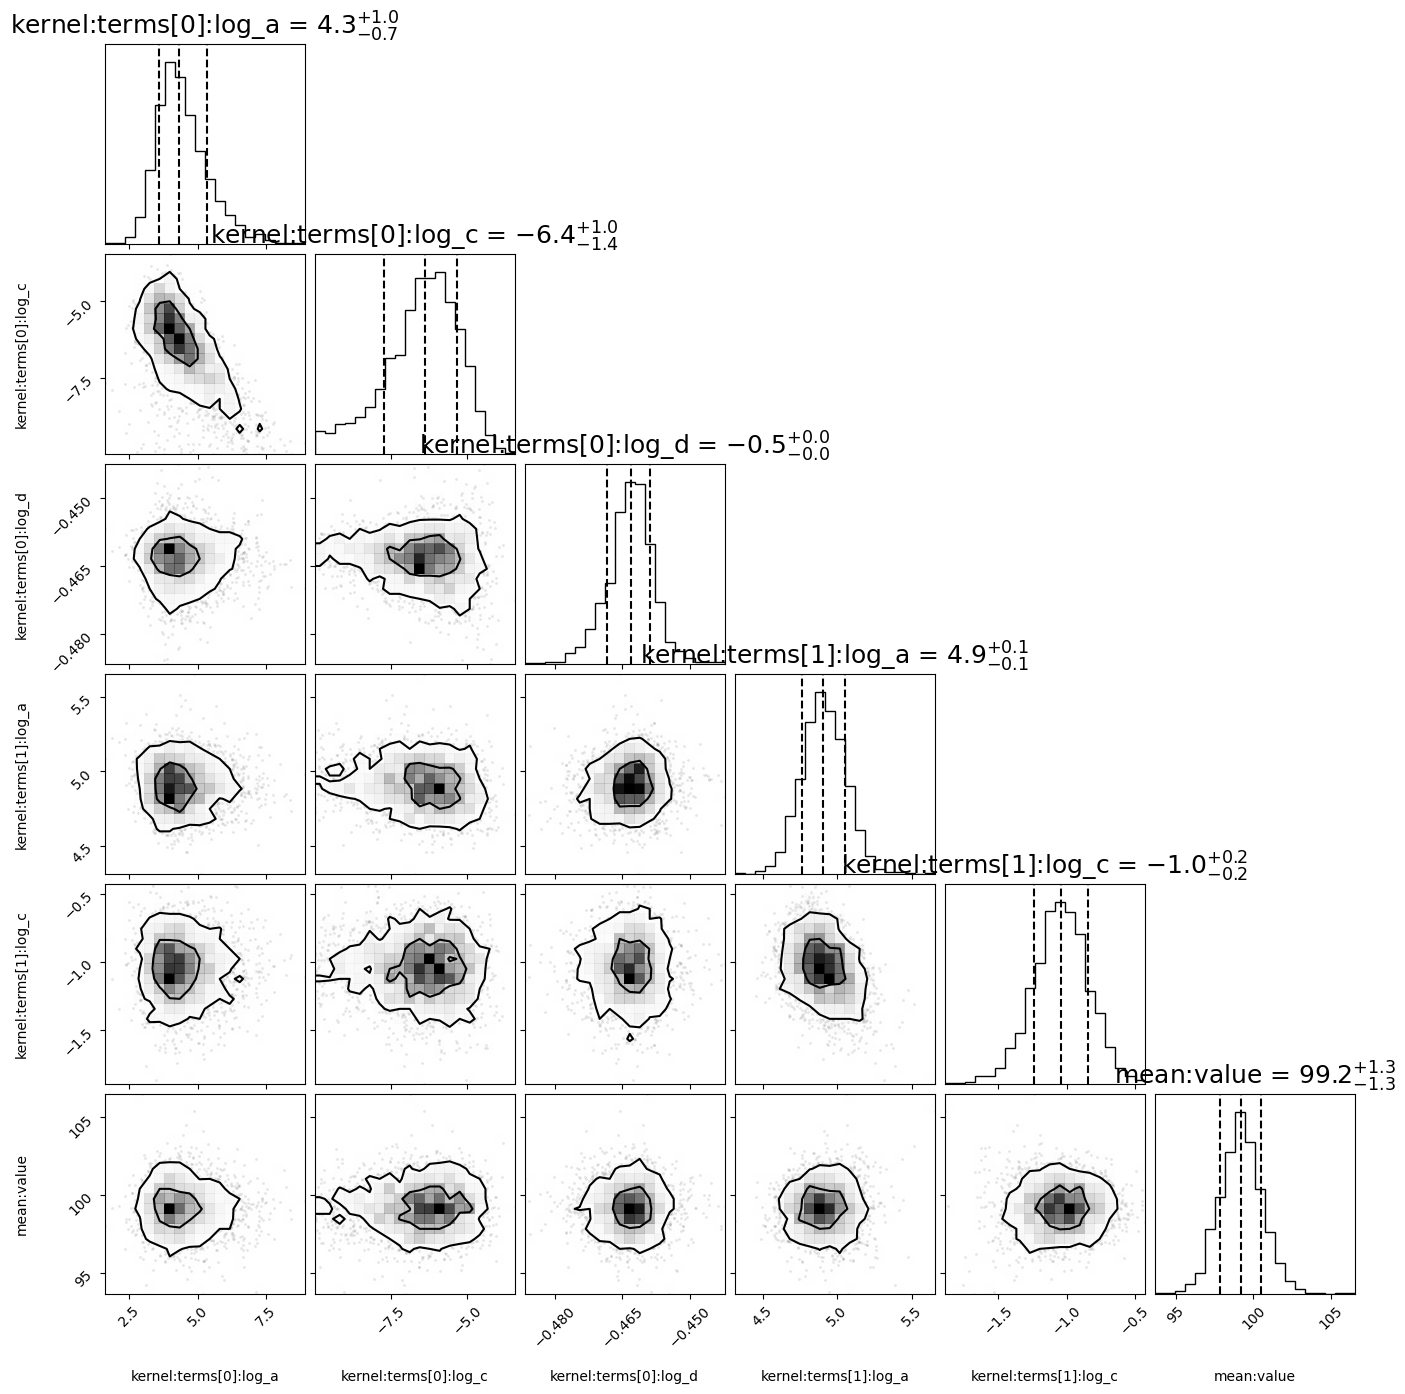

In [35]:
gp_model_comp.alt_model.plot_autocorrelation()
gp_model_comp.alt_model.corner_plot_samples()

# Generate lightcurves, and fit with both null and alternative models

In [ ]:
gp_model_comp.process_lightcurves(nsims=100, fit=True, max_steps=1000, cores=cpus)

# Perform Likelihood Ratio Test

In [ ]:
gp_model_comp.likelihood_ratio_test(path="LRT_no_period.png")